In [1]:
import tensorflow as tf
from dataset import load_dataset_from_tfrecord
import os
from io import StringIO
import wandb
from loss_functions import ssim_loss, combined_loss, custom_ssim_loss, custom_multi_ssim_loss
from tensorflow.keras import layers, models
import cv2
from image_utils import display_images_statistics_and_histograms
from evaluation import calculate_fmi
import numpy as np

print("Is eager execution enabled?:", tf.executing_eagerly())
# Check if GPU is available
print(tf.config.list_physical_devices('GPU'))

2.10.0
Is eager execution enabled?: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Load the dataset
modalities = ['t2w', 't1w']
loaded_dataset = load_dataset_from_tfrecord(os.path.join('datasets', '_'.join(modalities) + '_dataset.tfrecord'), modalities)

DATASET_SIZE = sum(1 for _ in loaded_dataset)
TRAIN_SIZE = int(0.8 * DATASET_SIZE)
VAL_SIZE = int(0.1 * DATASET_SIZE)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

# Shuffle the dataset
full_dataset = loaded_dataset.shuffle(buffer_size=DATASET_SIZE)

# Split the dataset
train_dataset = full_dataset.take(TRAIN_SIZE)
test_val_dataset = full_dataset.skip(TRAIN_SIZE)
val_dataset = test_val_dataset.take(VAL_SIZE)
test_dataset = test_val_dataset.skip(VAL_SIZE)

BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# # Print an example of the dataset
# for example in train_dataset.take(1):
#     print(example)
#     print(example['t2w'].shape)
#     print(example['t1w'].shape)


In [3]:
# Ajouter des branches pour d'autres contrastes T1w,T2w,T2*w,MT-on,GRE-T1wandDWI

def multi_scale_features(input_tensor, filters, name_prefix):
    # Path 1: Original scale
    path1 = layers.Conv2D(filters, 3, padding='same', name=name_prefix+'_conv1')(input_tensor)
    path1 = layers.BatchNormalization(name=name_prefix+'_bn1')(path1)
    path1 = layers.ReLU(name=name_prefix+'_relu1')(path1)

    # Path 2: Down-sampled scale
    path2 = layers.Conv2D(filters, 3, strides=2, padding='same', name=name_prefix+'_conv2')(input_tensor)
    path2 = layers.BatchNormalization(name=name_prefix+'_bn2')(path2)
    path2 = layers.ReLU(name=name_prefix+'_relu2')(path2)
    # Upsample to original size
    path2 = layers.UpSampling2D(size=(2, 2), name=name_prefix+'_upsample2')(path2)

    # Combine multi-scale features
    combined_features = layers.Concatenate(axis=-1)([path1, path2])
    return combined_features

# def build_model(input_shapes):
#     inputs = [layers.Input(shape=shape, name=f'image{i+1}') for i, shape in enumerate(input_shapes)]
#     multi_scale_branches = []

#     for i, input_tensor in enumerate(inputs):
#         # Extract multi-scale features
#         ms_features = multi_scale_features(input_tensor, 32, name_prefix=f'ms_branch{i+1}')
#         # Pass the combined features through a residual block
#         res_block = residual_block(ms_features, 64, name=f'res_block_ms_branch{i+1}')
#         multi_scale_branches.append(res_block)
# 
    # if len(multi_scale_branches) > 1:
    #     concatenated_features = layers.Concatenate(axis=-1)(multi_scale_branches)
    # else:
    #     concatenated_features = multi_scale_branches[0]
#  # Final layers after fusion
#     res_block_concat = residual_block(concatenated_features, 128, name='res_block_concat')
    # conv2 = layers.Conv2D(32, 3, strides=1, padding='same', name='conv2')(res_block_concat)
    # conv3 = layers.Conv2D(1, 3, strides=1, padding='same', name='conv3')(conv2)

    # sigmoid_output = layers.Activation('sigmoid')(conv3)
    # weighted_avg_inputs = layers.Average()(inputs + [sigmoid_output])


#     model = models.Model(inputs=inputs, outputs=weighted_avg_inputs)
#     return model


def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', name=name+'_shortcut')(shortcut)
        shortcut = layers.BatchNormalization(name=name+'_shortcut_bn')(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', name=name+'_conv1')(x)
    x = layers.BatchNormalization(name=name+'_bn1')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name+'_conv2')(x)
    x = layers.BatchNormalization(name=name+'_bn2')(x)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

def build_model(input_shapes):
    inputs = [layers.Input(shape=shape, name=f'image{i+1}') for i, shape in enumerate(input_shapes)]
    branches = []

    for i, input_tensor in enumerate(inputs):
        conv1 = layers.Conv2D(32, 3, strides=1, padding='same', name=f'conv1_branch{i+1}')(input_tensor)
        res_block = residual_block(conv1, 32, name=f'res_block_branch{i+1}')
        branches.append(res_block)

    if len(branches) > 1:
        concatenated_features = layers.Concatenate(axis=-1)(branches)
    else:
        concatenated_features = branches[0]

    res_block_concat = residual_block(concatenated_features, 64, name='res_block_concat')

    conv2 = layers.Conv2D(32, 3, strides=1, padding='same', name='conv2')(res_block_concat)
    conv3 = layers.Conv2D(1, 3, strides=1, padding='same', name='conv3')(conv2)

    sigmoid_output = layers.Activation('sigmoid')(conv3)
    weighted_avg_inputs = layers.Average()(inputs + [sigmoid_output])

    model = models.Model(inputs=inputs, outputs=weighted_avg_inputs)
    return model

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: biancapopa. Use `wandb login --relogin` to force relogin


Statistics for Patient b'sub-mniS07':
T2W - Mean: 29.18, Std Dev: 45.05, Skewness: 2.16, Kurtosis: 4.65
T1W - Mean: 30.44, Std Dev: 38.92, Skewness: 1.23, Kurtosis: 0.88
Output - Mean: 25.96, Std Dev: 32.66, Skewness: 1.58, Kurtosis: 2.01
Edge Proportion - T2W: 0.52, T1W: 0.52, Output: 0.48
Middle Proportion - T2W: 0.48, T1W: 0.48, Output: 0.52


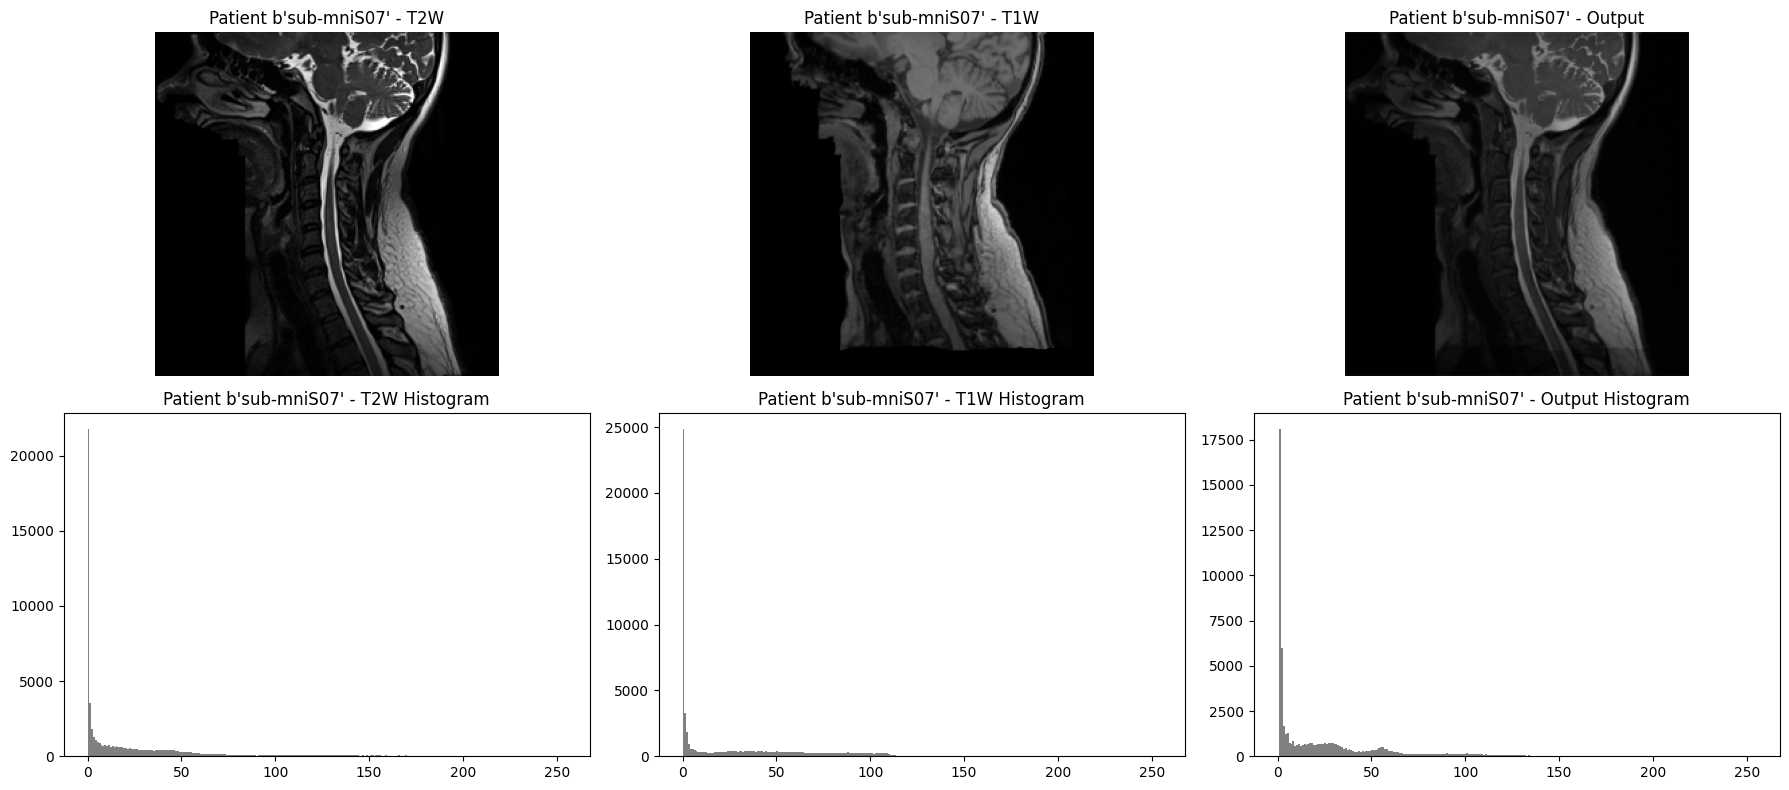

Epoch 1, Training Loss: 0.07405585050582886, Validation Loss: 0.24107927083969116
Statistics for Patient b'sub-cmrra01':
T2W - Mean: 20.33, Std Dev: 36.68, Skewness: 2.55, Kurtosis: 7.25
T1W - Mean: 30.81, Std Dev: 38.74, Skewness: 1.10, Kurtosis: 0.02
Output - Mean: 21.68, Std Dev: 30.59, Skewness: 1.92, Kurtosis: 3.71
Edge Proportion - T2W: 0.66, T1W: 0.51, Output: 0.55
Middle Proportion - T2W: 0.34, T1W: 0.49, Output: 0.45


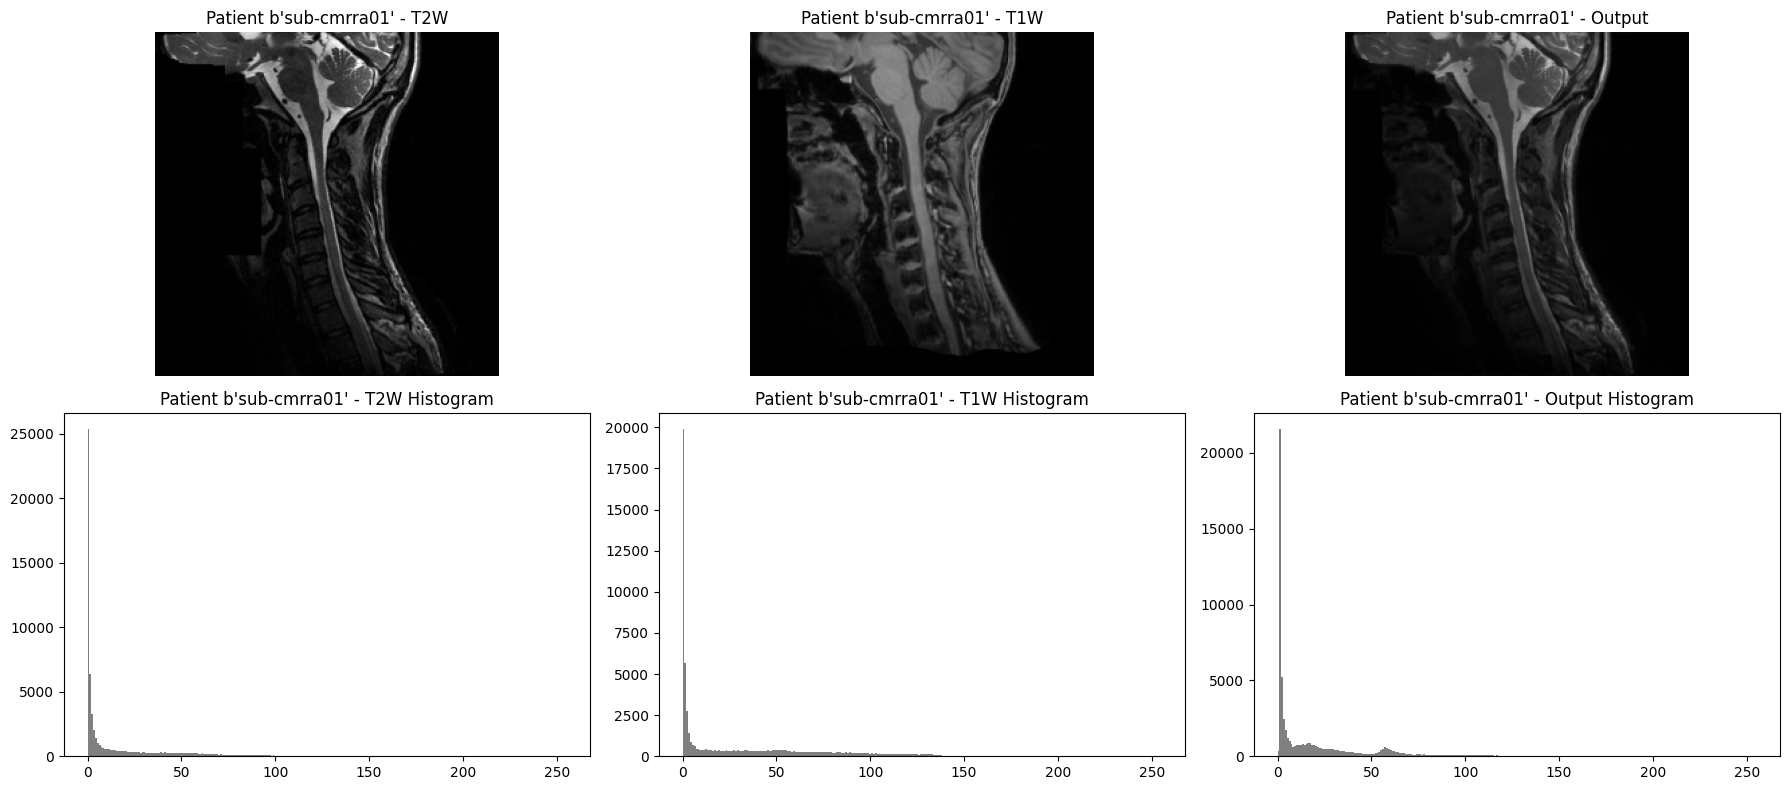

Epoch 2, Training Loss: 0.06303351372480392, Validation Loss: 0.12808047235012054
Statistics for Patient b'sub-mpicbs01':
T2W - Mean: 24.16, Std Dev: 43.56, Skewness: 2.51, Kurtosis: 6.62
T1W - Mean: 29.68, Std Dev: 40.90, Skewness: 1.20, Kurtosis: 0.18
Output - Mean: 24.85, Std Dev: 40.46, Skewness: 2.16, Kurtosis: 4.60
Edge Proportion - T2W: 0.63, T1W: 0.57, Output: 0.59
Middle Proportion - T2W: 0.37, T1W: 0.43, Output: 0.41


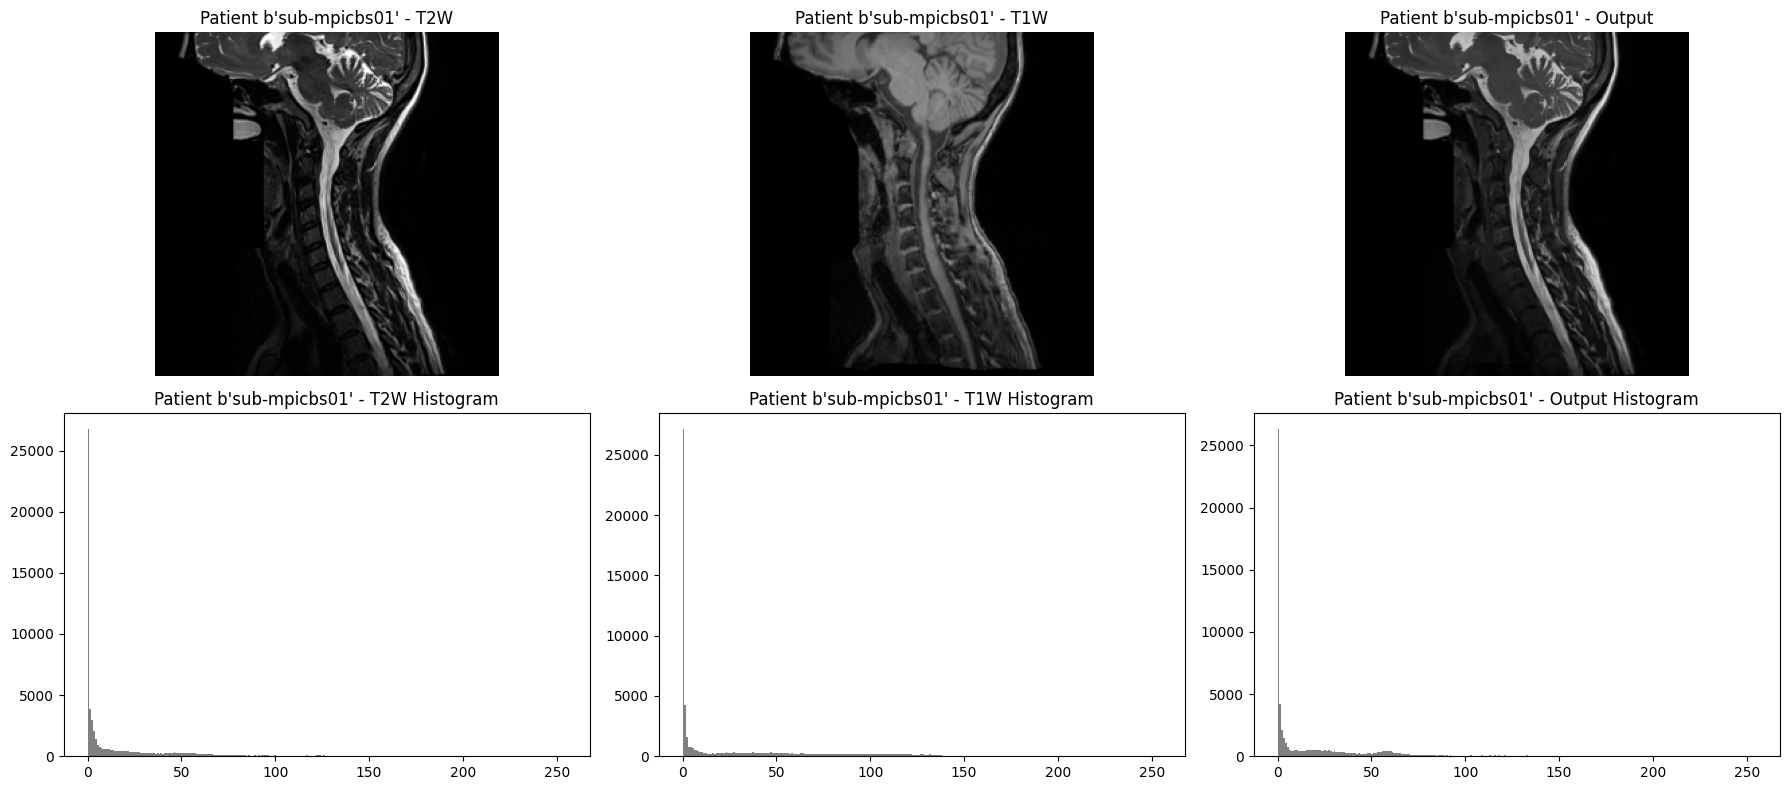

Epoch 3, Training Loss: 0.0627296045422554, Validation Loss: 0.0737123191356659
Statistics for Patient b'sub-brnoCeitec02':
T2W - Mean: 28.81, Std Dev: 49.10, Skewness: 2.49, Kurtosis: 6.64
T1W - Mean: 27.86, Std Dev: 38.83, Skewness: 1.35, Kurtosis: 0.71
Output - Mean: 28.12, Std Dev: 44.36, Skewness: 2.02, Kurtosis: 3.61
Edge Proportion - T2W: 0.59, T1W: 0.57, Output: 0.56
Middle Proportion - T2W: 0.41, T1W: 0.43, Output: 0.44


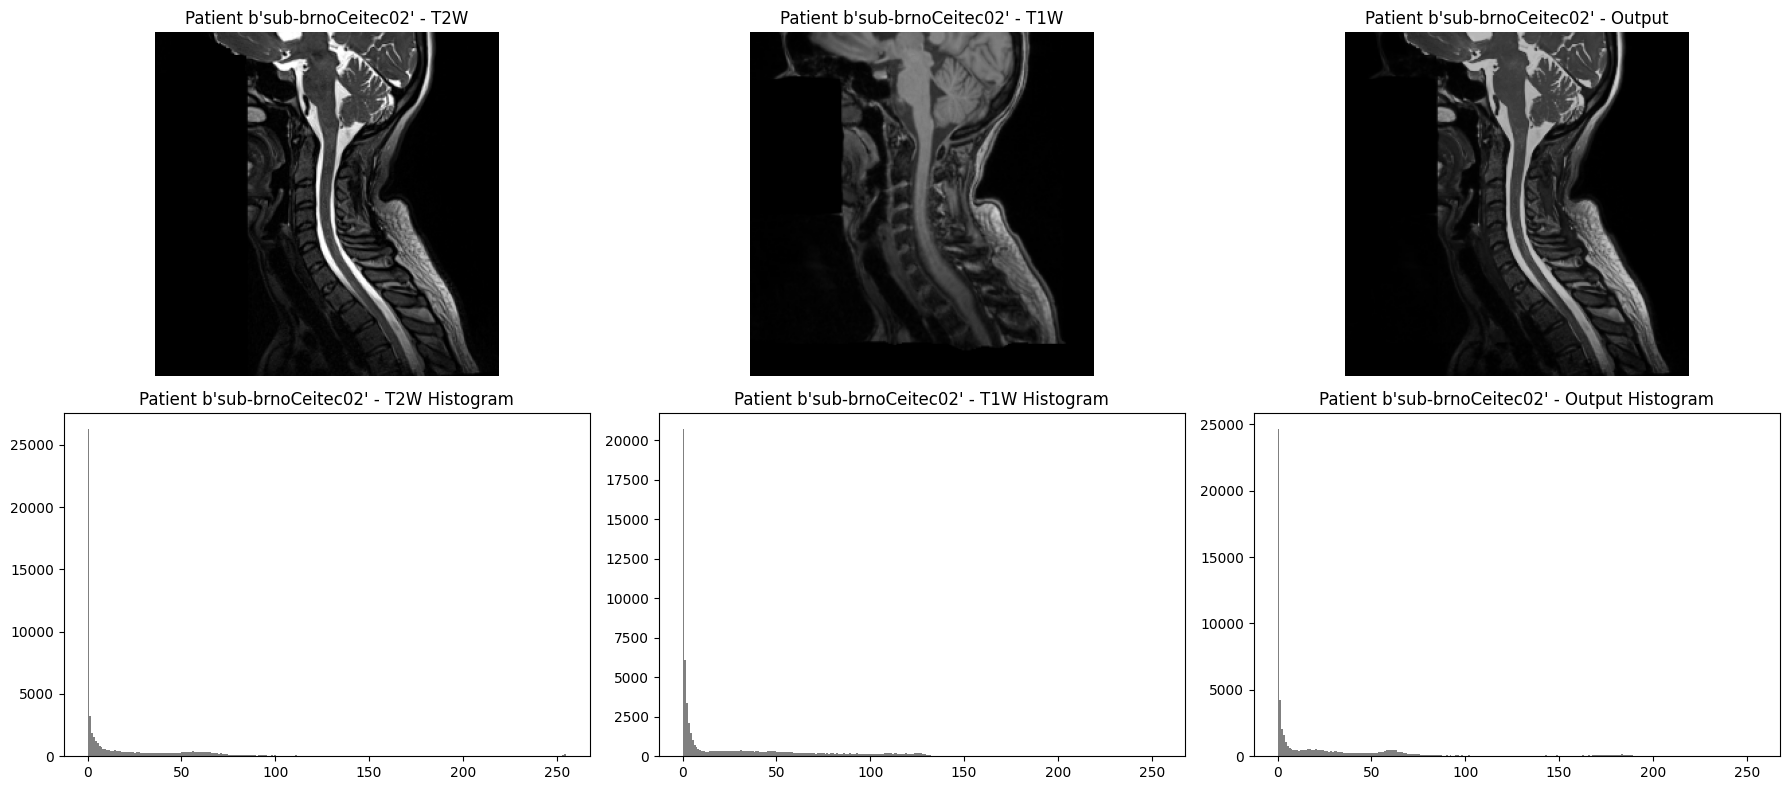

Epoch 4, Training Loss: 0.061561357229948044, Validation Loss: 0.05939188227057457
Statistics for Patient b'sub-cardiff01':
T2W - Mean: 35.97, Std Dev: 57.14, Skewness: 2.15, Kurtosis: 4.30
T1W - Mean: 33.77, Std Dev: 41.75, Skewness: 1.12, Kurtosis: 0.49
Output - Mean: 37.58, Std Dev: 54.84, Skewness: 1.74, Kurtosis: 2.20
Edge Proportion - T2W: 0.54, T1W: 0.49, Output: 0.48
Middle Proportion - T2W: 0.46, T1W: 0.51, Output: 0.52


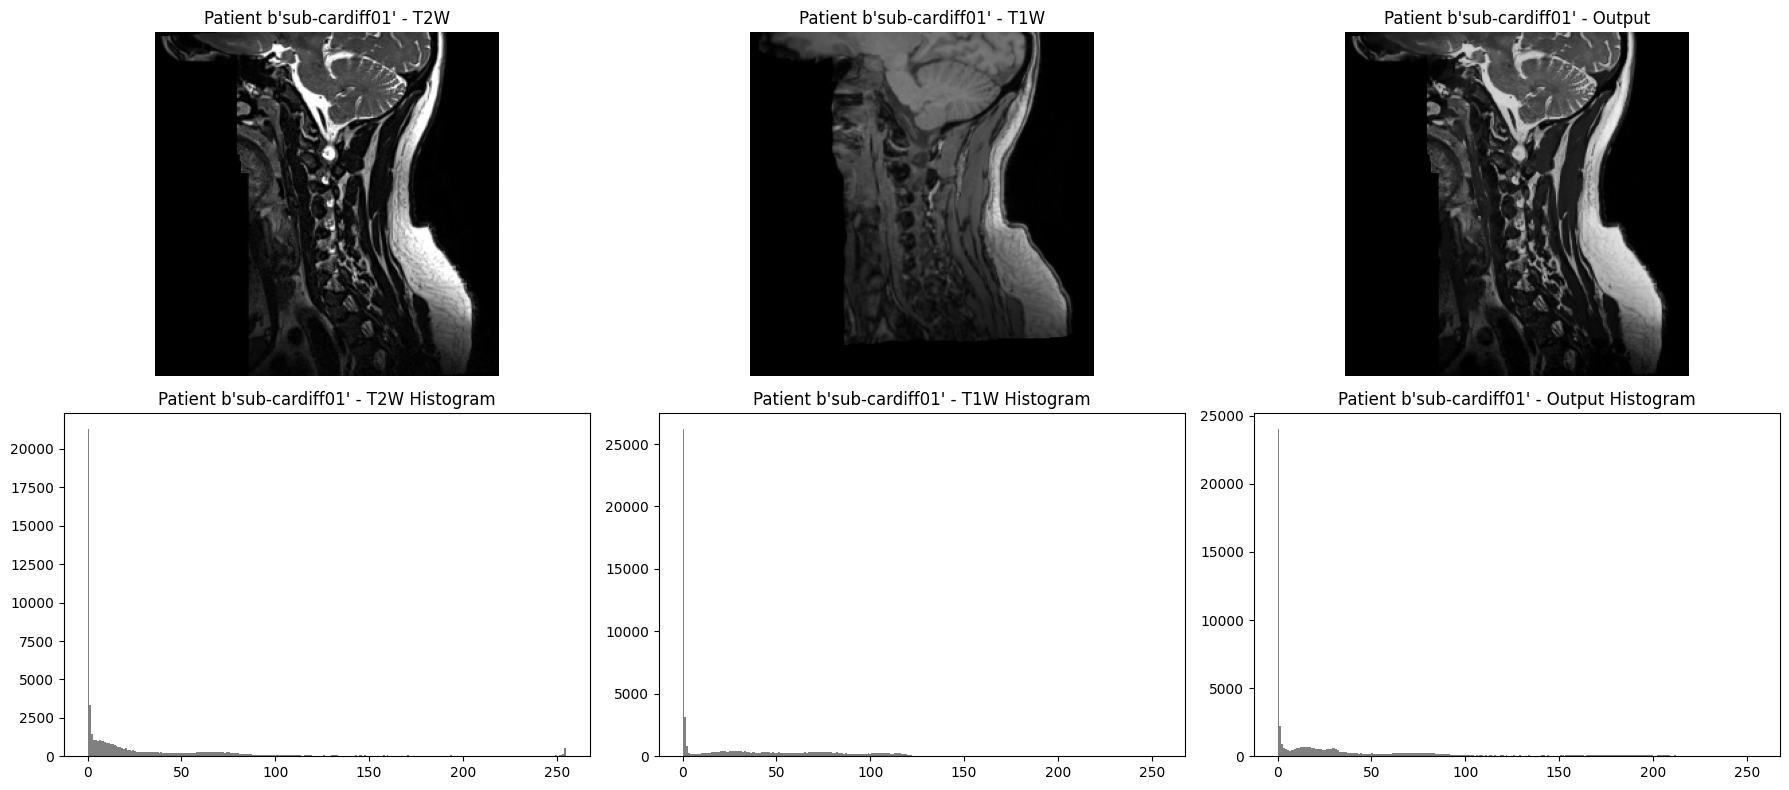

Epoch 5, Training Loss: 0.060369741171598434, Validation Loss: 0.06073940917849541
Statistics for Patient b'sub-mountSinai03':
T2W - Mean: 30.19, Std Dev: 48.85, Skewness: 2.29, Kurtosis: 5.35
T1W - Mean: 27.77, Std Dev: 35.25, Skewness: 1.17, Kurtosis: 0.24
Output - Mean: 31.55, Std Dev: 48.08, Skewness: 1.88, Kurtosis: 2.72
Edge Proportion - T2W: 0.56, T1W: 0.51, Output: 0.51
Middle Proportion - T2W: 0.44, T1W: 0.49, Output: 0.49


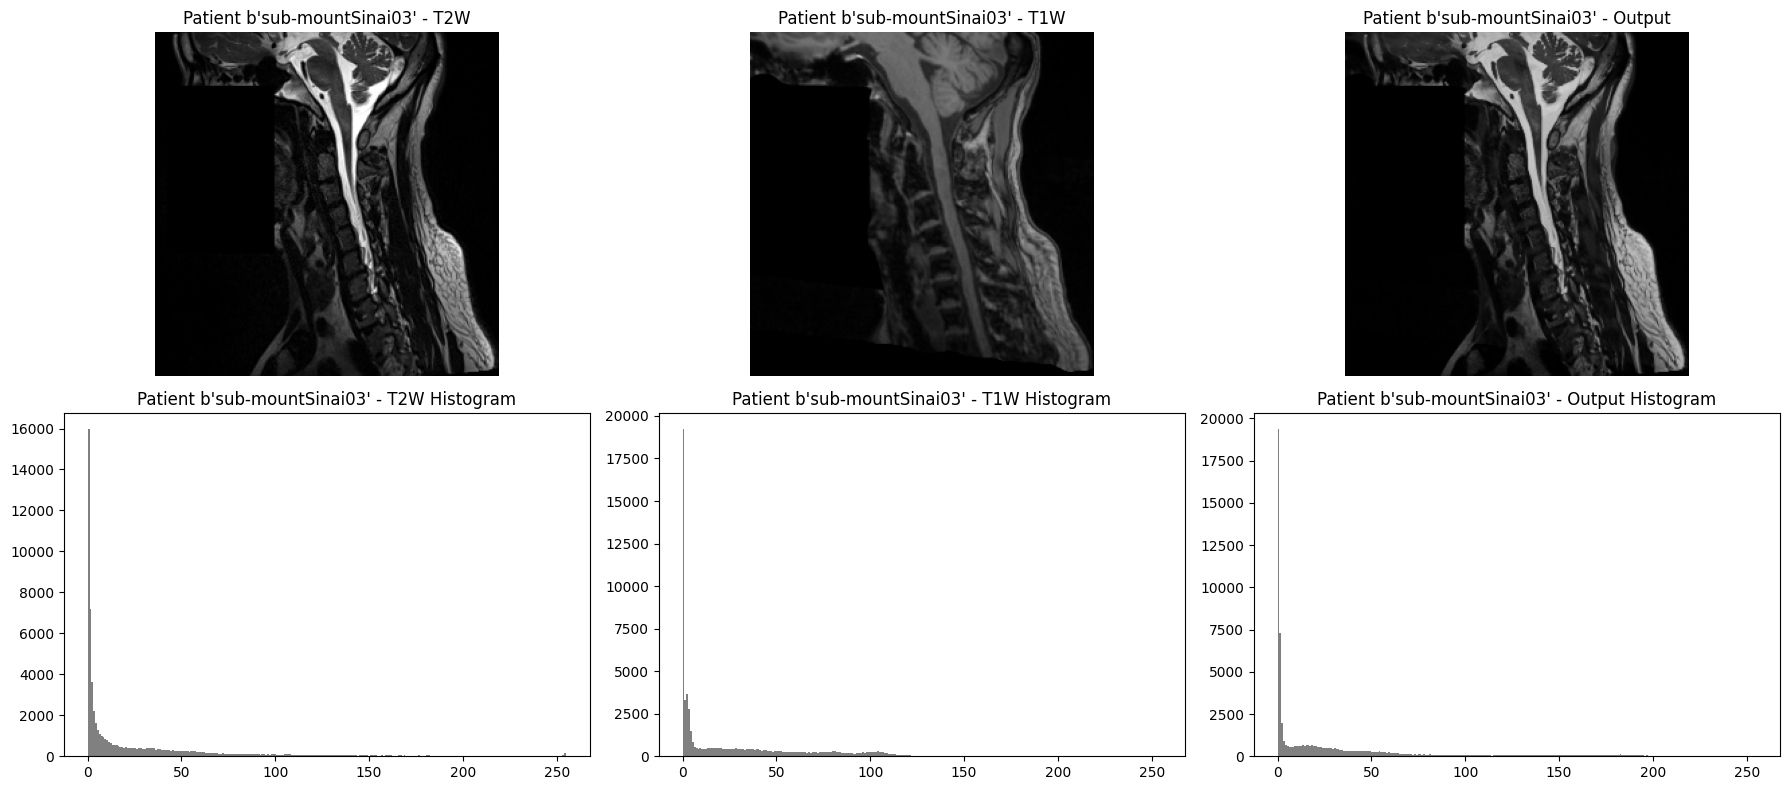

Epoch 6, Training Loss: 0.06150708347558975, Validation Loss: 0.0584639310836792
Statistics for Patient b'sub-barcelona01':
T2W - Mean: 29.58, Std Dev: 48.24, Skewness: 2.22, Kurtosis: 4.94
T1W - Mean: 34.25, Std Dev: 41.84, Skewness: 1.04, Kurtosis: -0.00
Output - Mean: 30.83, Std Dev: 47.34, Skewness: 1.93, Kurtosis: 3.06
Edge Proportion - T2W: 0.57, T1W: 0.49, Output: 0.53
Middle Proportion - T2W: 0.43, T1W: 0.51, Output: 0.47


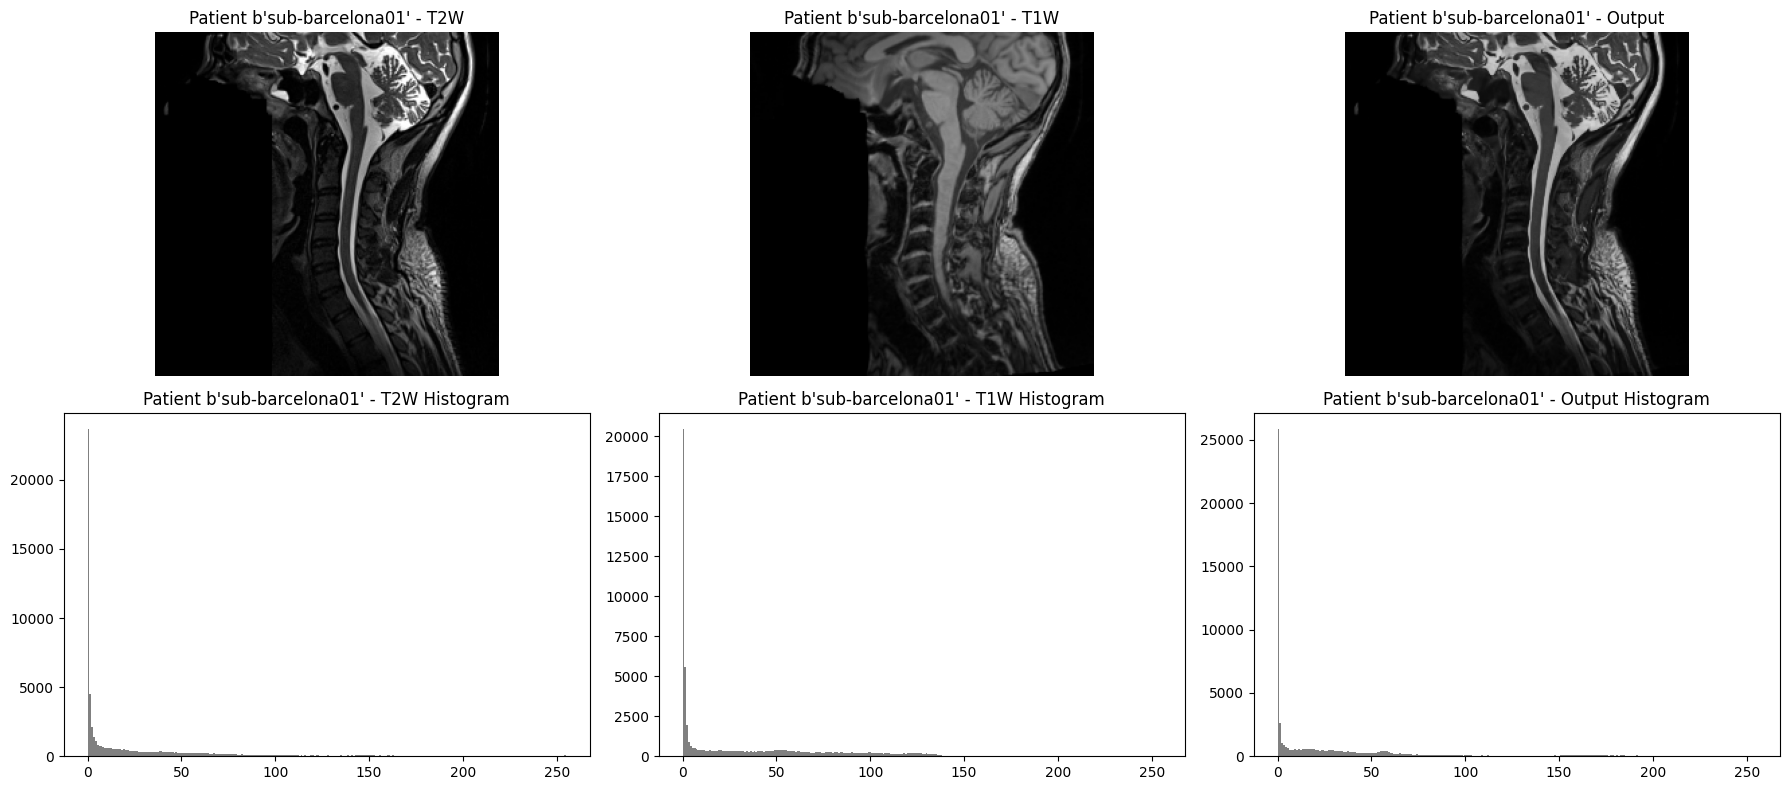

Epoch 7, Training Loss: 0.06052310764789581, Validation Loss: 0.06014042720198631
Statistics for Patient b'sub-hamburg03':
T2W - Mean: 30.94, Std Dev: 53.87, Skewness: 2.35, Kurtosis: 5.57
T1W - Mean: 28.05, Std Dev: 40.66, Skewness: 1.38, Kurtosis: 0.95
Output - Mean: 32.20, Std Dev: 51.58, Skewness: 1.84, Kurtosis: 2.57
Edge Proportion - T2W: 0.62, T1W: 0.59, Output: 0.57
Middle Proportion - T2W: 0.38, T1W: 0.41, Output: 0.43


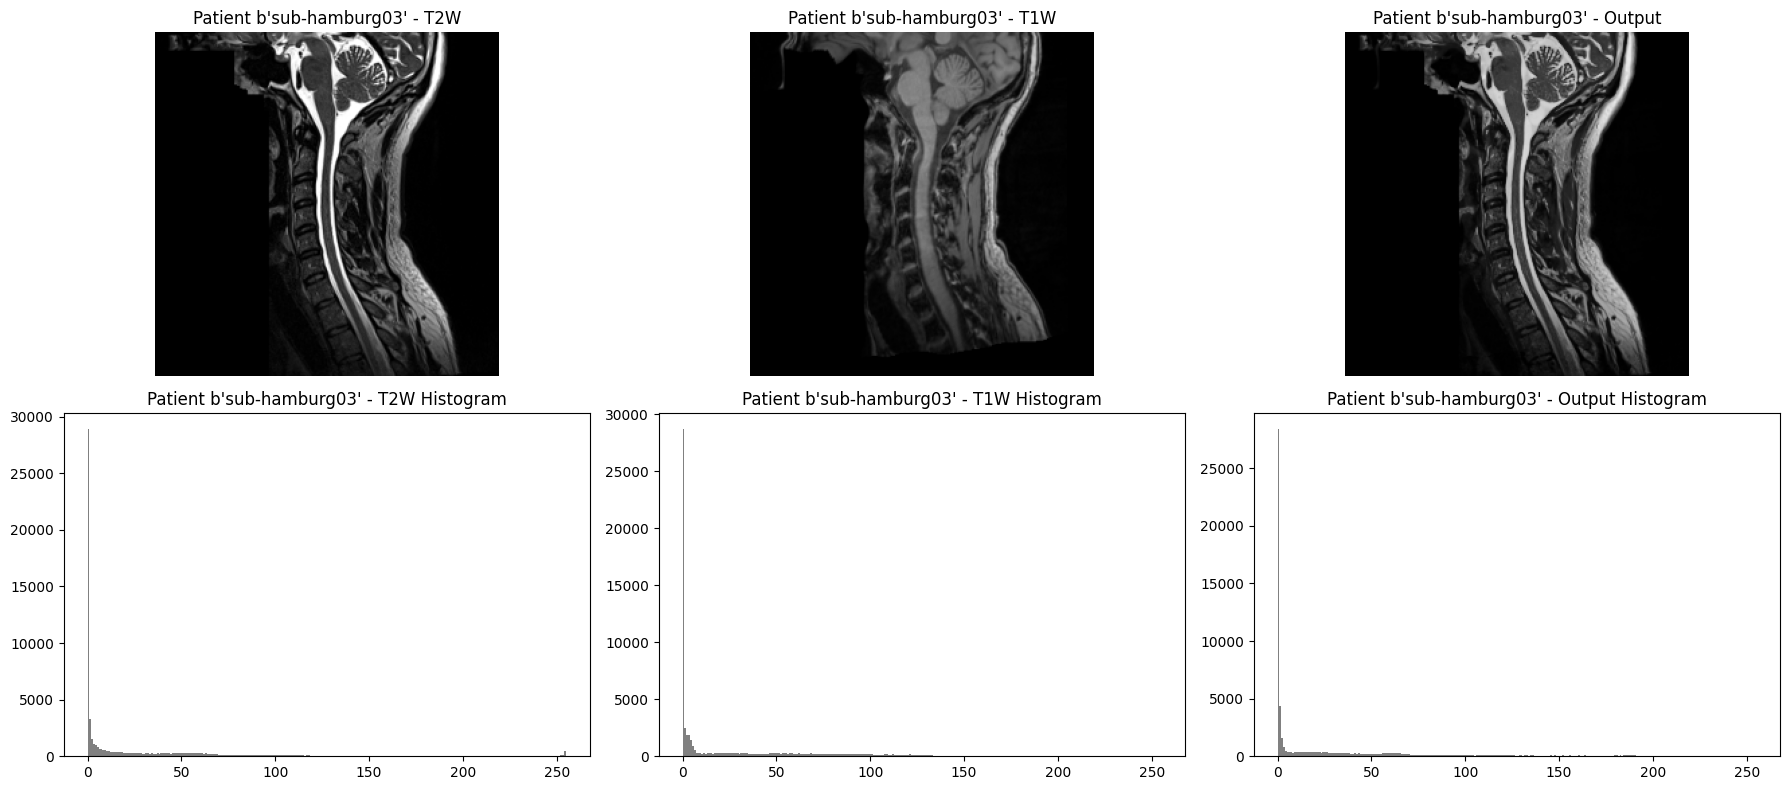

Epoch 8, Training Loss: 0.060650669038295746, Validation Loss: 0.06300132721662521
Statistics for Patient b'sub-pavia06':
T2W - Mean: 25.79, Std Dev: 47.53, Skewness: 2.88, Kurtosis: 8.89
T1W - Mean: 23.33, Std Dev: 29.68, Skewness: 1.03, Kurtosis: -0.25
Output - Mean: 25.90, Std Dev: 42.62, Skewness: 2.28, Kurtosis: 4.92
Edge Proportion - T2W: 0.60, T1W: 0.54, Output: 0.54
Middle Proportion - T2W: 0.40, T1W: 0.46, Output: 0.46


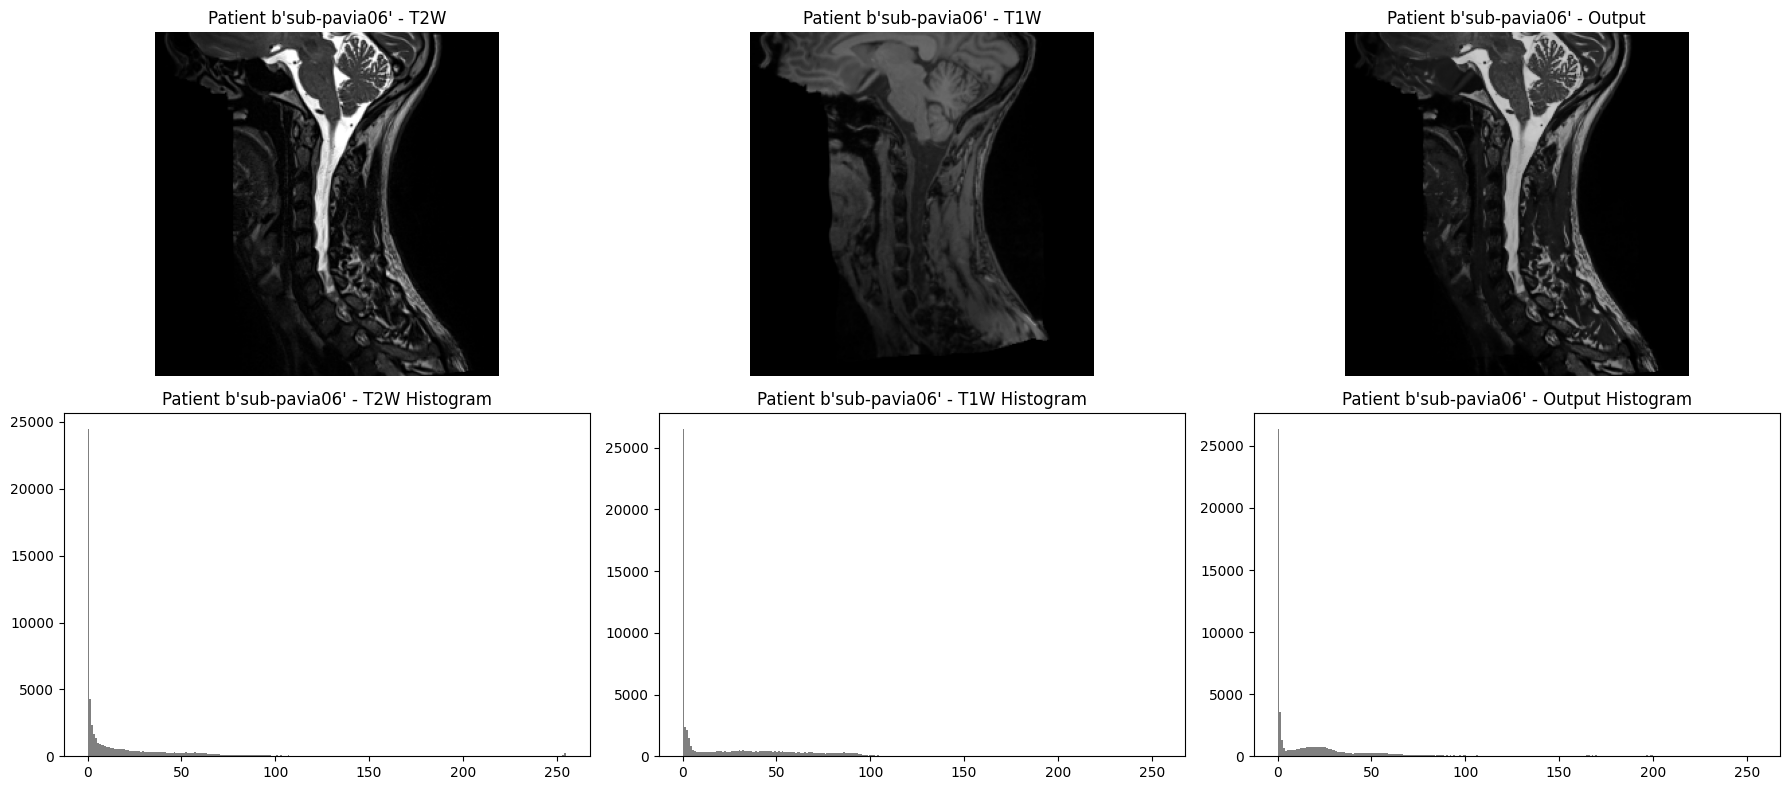

Epoch 9, Training Loss: 0.061978891491889954, Validation Loss: 0.05832798779010773
Statistics for Patient b'sub-tehranS06':
T2W - Mean: 29.96, Std Dev: 49.14, Skewness: 2.20, Kurtosis: 4.57
T1W - Mean: 36.23, Std Dev: 45.39, Skewness: 1.04, Kurtosis: 0.05
Output - Mean: 32.01, Std Dev: 48.98, Skewness: 1.97, Kurtosis: 3.22
Edge Proportion - T2W: 0.56, T1W: 0.51, Output: 0.50
Middle Proportion - T2W: 0.44, T1W: 0.49, Output: 0.50


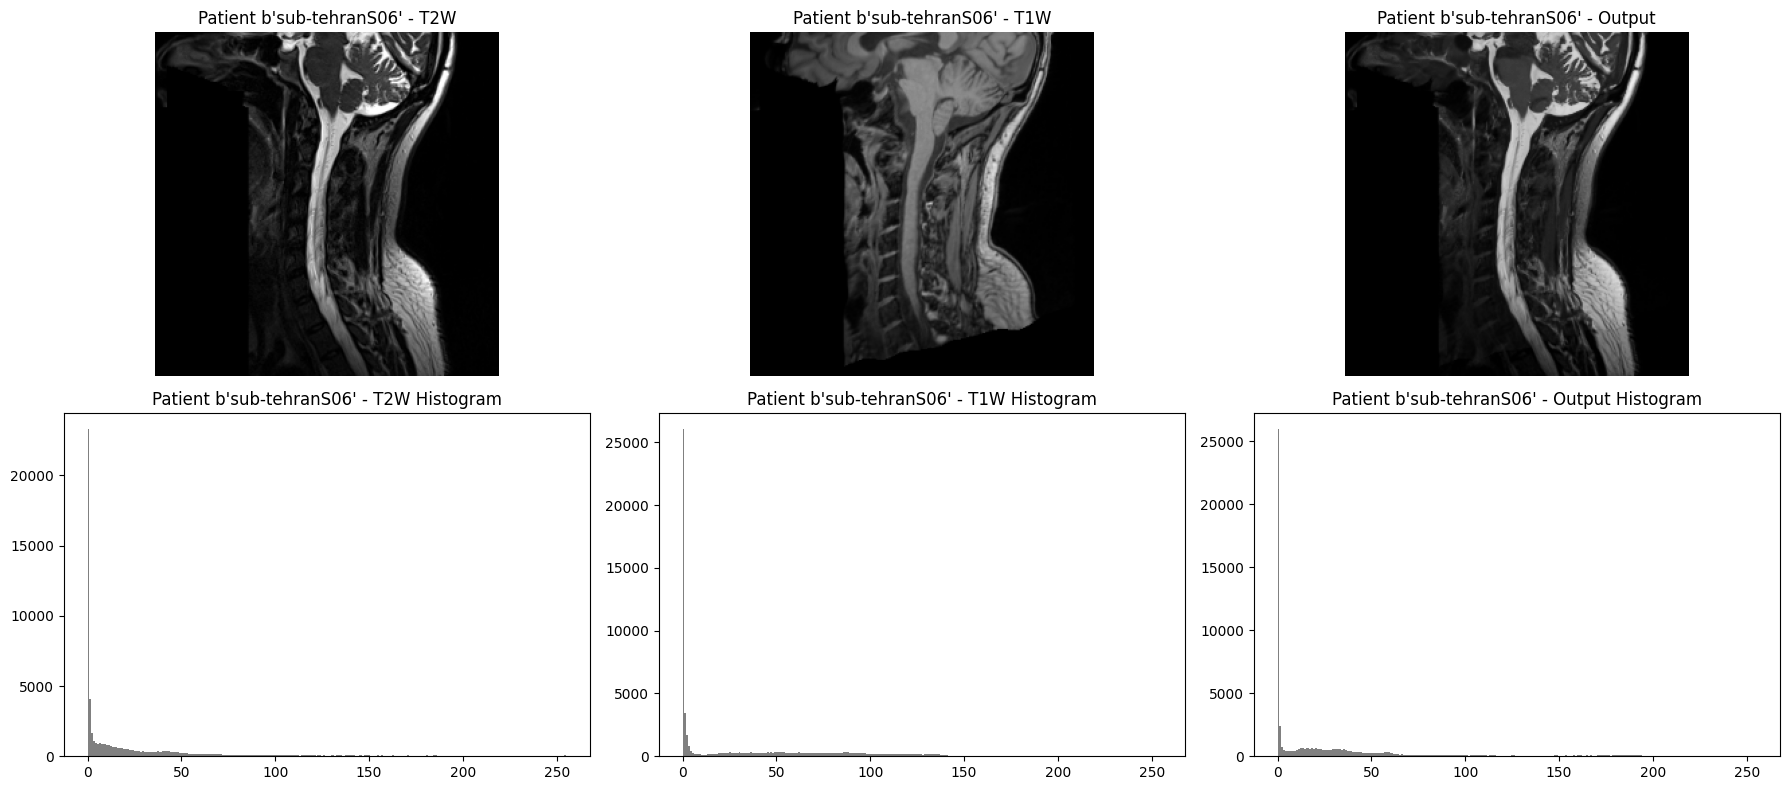

Epoch 10, Training Loss: 0.06135139241814613, Validation Loss: 0.060777436941862106
Statistics for Patient b'sub-cardiff03':
T2W - Mean: 27.93, Std Dev: 46.45, Skewness: 2.52, Kurtosis: 7.09
T1W - Mean: 30.15, Std Dev: 40.10, Skewness: 1.13, Kurtosis: -0.02
Output - Mean: 28.00, Std Dev: 43.14, Skewness: 1.99, Kurtosis: 3.68
Edge Proportion - T2W: 0.57, T1W: 0.55, Output: 0.55
Middle Proportion - T2W: 0.43, T1W: 0.45, Output: 0.45


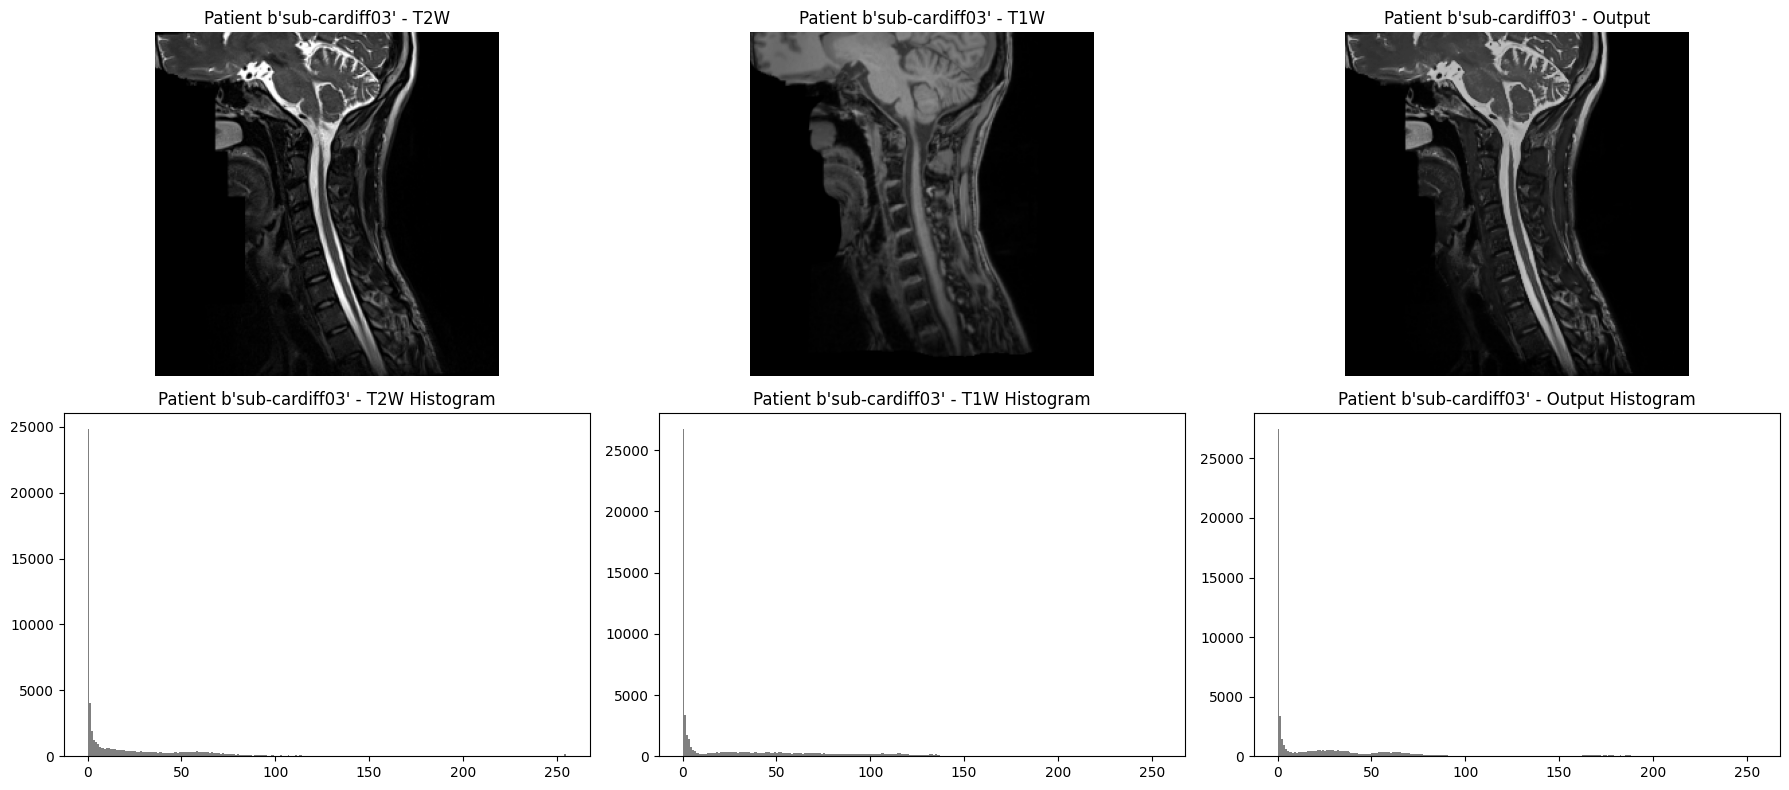

Epoch 11, Training Loss: 0.060586825013160706, Validation Loss: 0.05916202440857887
Statistics for Patient b'sub-ucdavis01':
T2W - Mean: 17.45, Std Dev: 30.27, Skewness: 2.34, Kurtosis: 5.32
T1W - Mean: 33.18, Std Dev: 44.65, Skewness: 1.12, Kurtosis: -0.08
Output - Mean: 22.89, Std Dev: 36.53, Skewness: 2.07, Kurtosis: 4.00
Edge Proportion - T2W: 0.65, T1W: 0.56, Output: 0.57
Middle Proportion - T2W: 0.35, T1W: 0.44, Output: 0.43


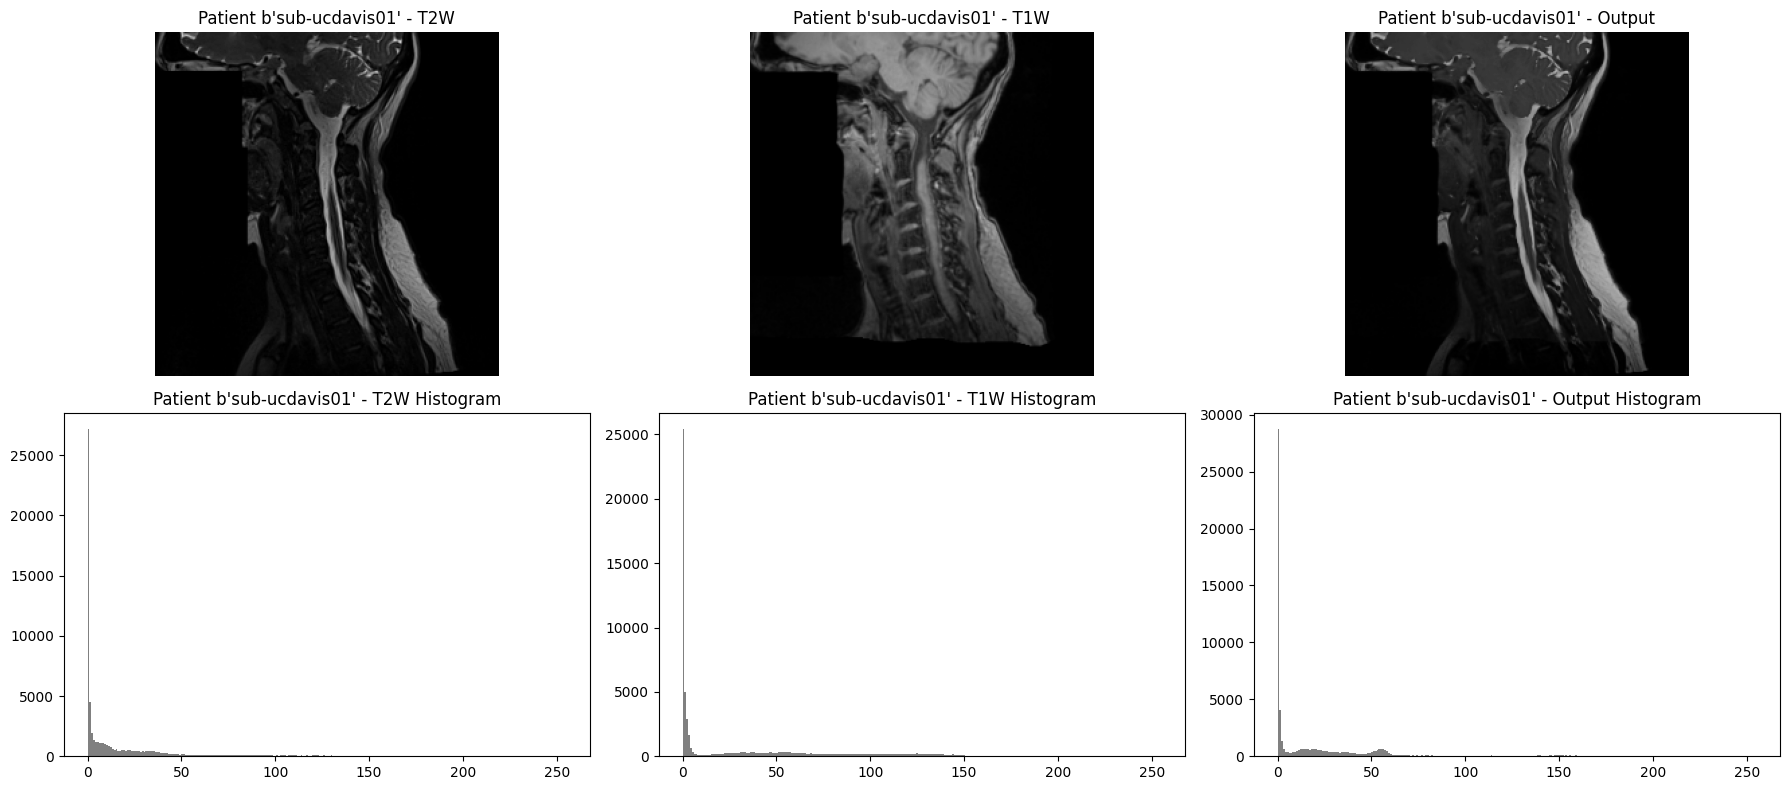

Epoch 12, Training Loss: 0.06151305511593819, Validation Loss: 0.06696172058582306
Statistics for Patient b'sub-balgrist04':
T2W - Mean: 23.69, Std Dev: 40.49, Skewness: 2.66, Kurtosis: 8.02
T1W - Mean: 25.44, Std Dev: 34.97, Skewness: 1.47, Kurtosis: 1.50
Output - Mean: 23.76, Std Dev: 38.66, Skewness: 2.34, Kurtosis: 5.31
Edge Proportion - T2W: 0.58, T1W: 0.55, Output: 0.56
Middle Proportion - T2W: 0.42, T1W: 0.45, Output: 0.44


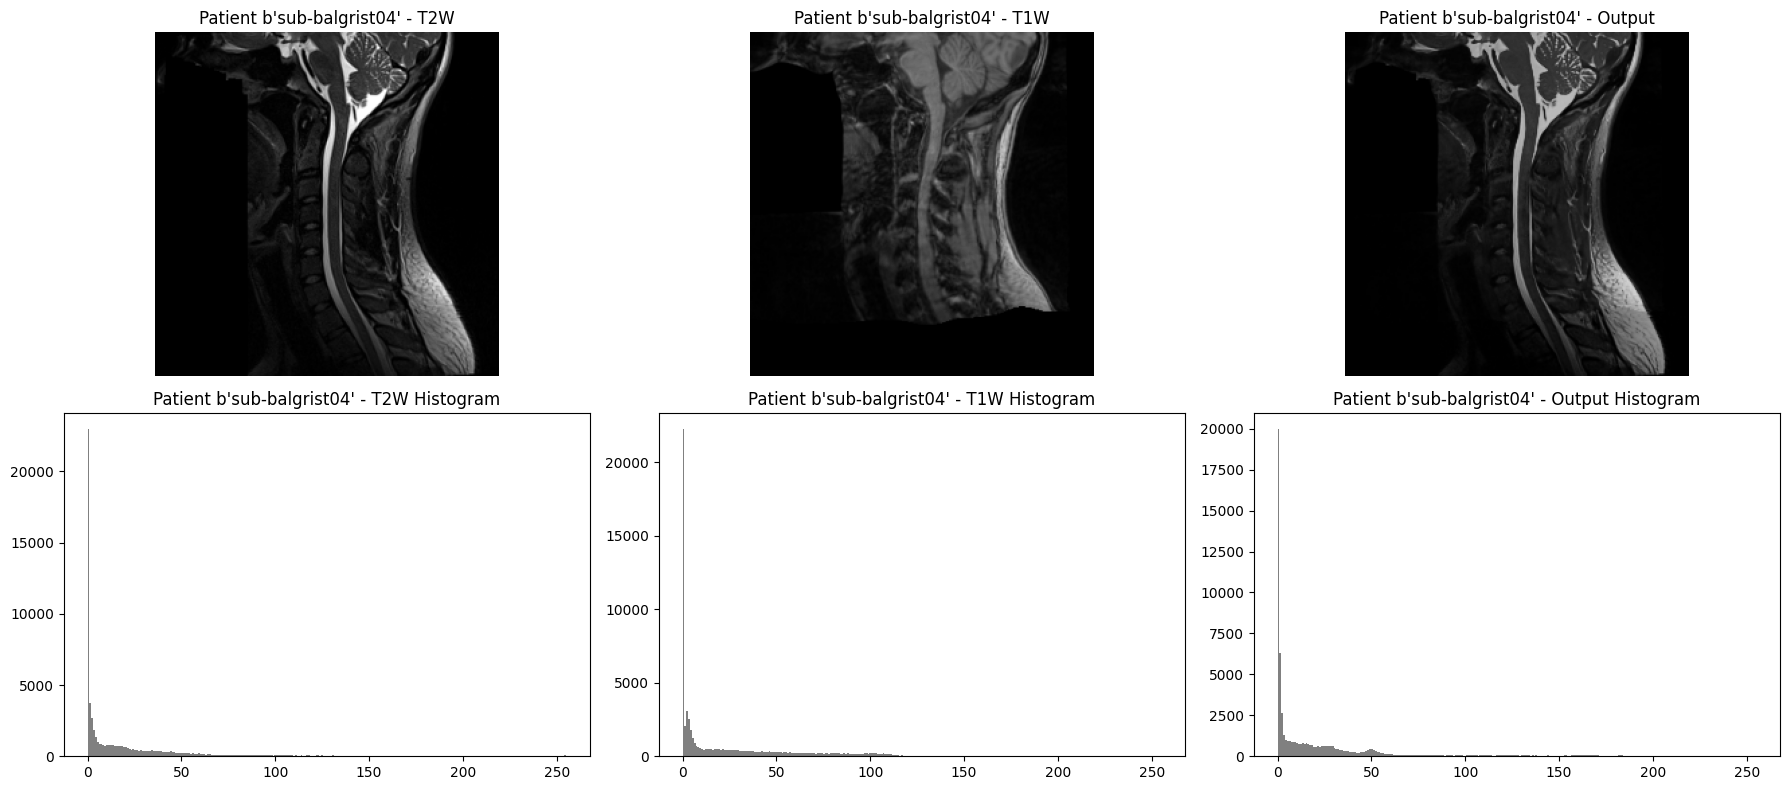

Epoch 13, Training Loss: 0.06049640104174614, Validation Loss: 0.06042809784412384
Statistics for Patient b'sub-fslAchieva04':
T2W - Mean: 18.90, Std Dev: 32.03, Skewness: 2.95, Kurtosis: 10.60
T1W - Mean: 33.99, Std Dev: 42.18, Skewness: 1.02, Kurtosis: -0.12
Output - Mean: 21.95, Std Dev: 33.87, Skewness: 2.65, Kurtosis: 8.59
Edge Proportion - T2W: 0.58, T1W: 0.50, Output: 0.52
Middle Proportion - T2W: 0.42, T1W: 0.50, Output: 0.48


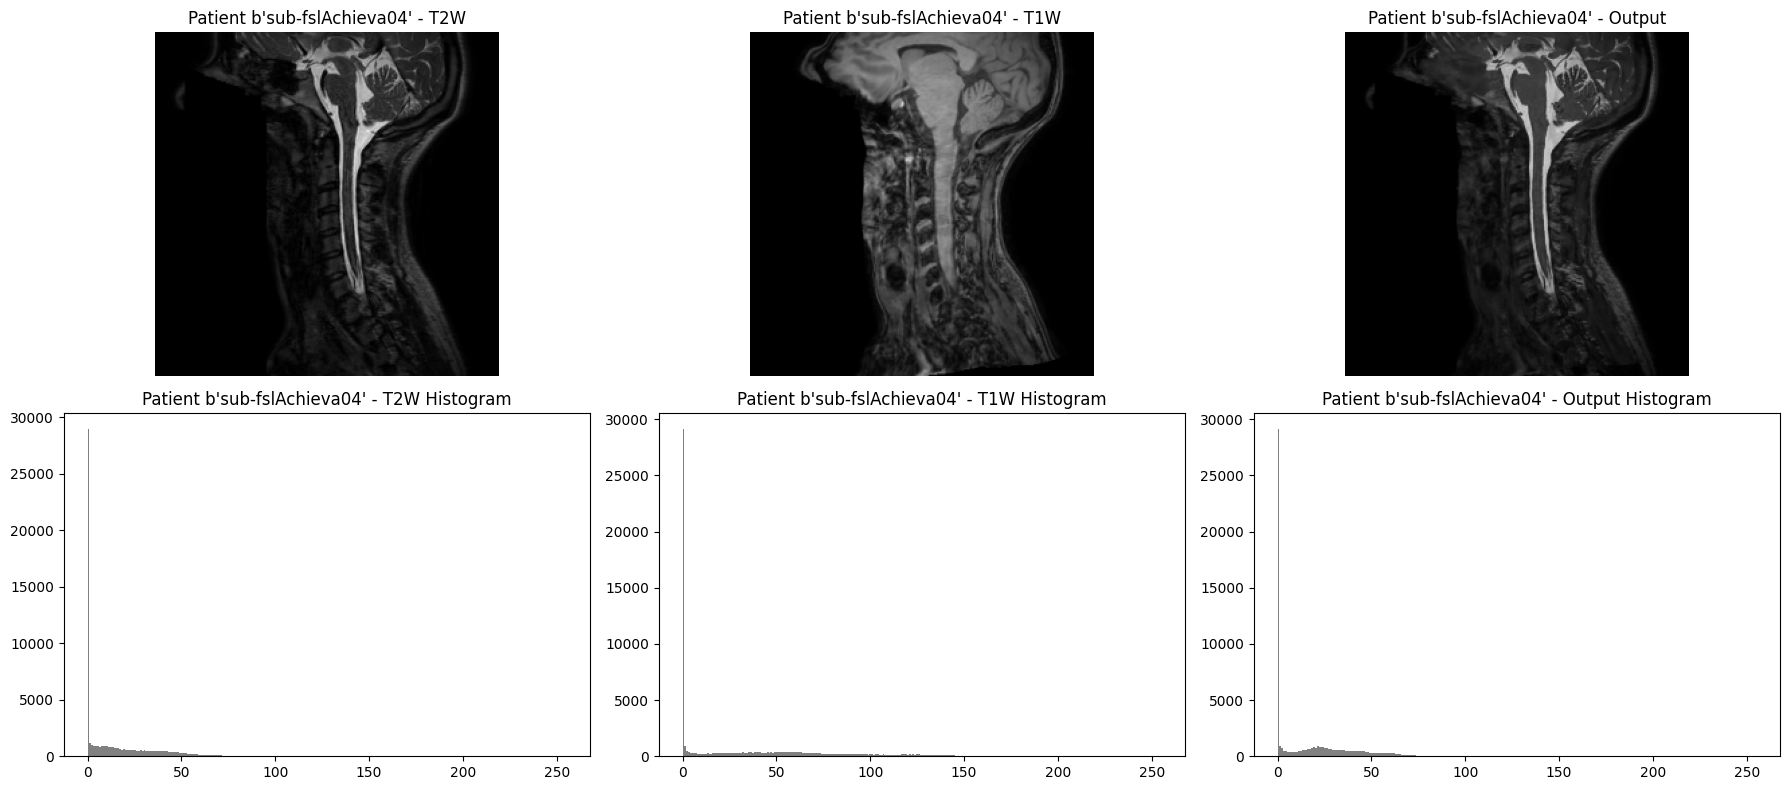

Epoch 14, Training Loss: 0.0604107640683651, Validation Loss: 0.05966977775096893
Early stopping due to no improvement in validation loss.
Training finished.
Best validation loss: tf.Tensor(0.058327988, shape=(), dtype=float32)
FMI on validation set: 0.8631130347848543


In [4]:
# Initialize Weights and Biases
wandb.init(project='multicontrast-fusion', entity='biancapopa')

model = build_model([(256, 256, 1), (256, 256, 1)])  # for 2 input branches

# Capture the model summary
str_buffer = StringIO()
model.summary(print_fn=lambda x: str_buffer.write(x + '\n'))
model_summary = str_buffer.getvalue()

with open("model_summary.txt", "w") as f:
    f.write(model_summary)


learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
max_epochs = 100

# Log hyperparameters
wandb.config.optimizer = 'Adam'
wandb.config.learning_rate = learning_rate
wandb.config.epochs = max_epochs

# Initialize metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

# Initialize early stopping parameters
best_val_loss = float('inf')
patience = 5
wait = 0

validation_fmi = []

@tf.function
def train_step(image1, image2, model, optimizer):
    with tf.GradientTape() as tape:
        output = model([image1, image2], training=True)
        loss = custom_multi_ssim_loss([image1, image2], output, alpha=1, beta=4, gamma=1) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

with tf.device('/GPU:0'): 
    for epoch in range(max_epochs):
        tf.config.run_functions_eagerly(False)

        train_loss.reset_states()
        val_loss.reset_states()
        
        for images in train_dataset:
            image1, image2 = images['t2w'], images['t1w']
            loss_val = train_step(image1, image2, model, optimizer)
            train_loss.update_state(loss_val)
        
        for images in val_dataset:
            image1, image2 = images['t2w'], images['t1w']
            val_output = model([image1, image2], training=False)
            current_val_loss = custom_multi_ssim_loss([image1, image2], val_output, alpha=1, beta=4, gamma=1)
            val_loss.update_state(current_val_loss)

        tf.config.run_functions_eagerly(False)

        # Display images for the first batch of the validation dataset after each epoch
        images = next(iter(val_dataset))
        image1, image2 = images['t2w'], images['t1w']
        patient_id = images['patient_id']
        val_output = model([image1, image2], training=False)
        
        display_images_statistics_and_histograms(image1[0], image2[0], val_output[0], patient_id[0])
        validation_fmi.append(calculate_fmi(image1, image2, val_output))

        # Log losses to Weights and Biases
        wandb.log({'epoch': epoch + 1, 'train_loss': train_loss.result().numpy(), 'val_loss': val_loss.result().numpy()})

        print(f"Epoch {epoch + 1}, Training Loss: {train_loss.result()}, Validation Loss: {val_loss.result()}")

        if val_loss.result() < best_val_loss:
            best_val_loss = val_loss.result()
            wait = 0
            
            # Log the best model
            wandb.log({'best_val_loss': best_val_loss.numpy()})
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

print("Training finished.")
print("Best validation loss:", best_val_loss)
print("FMI on validation set:", np.mean(validation_fmi))
model.save("model_name.h5")


In [8]:
test_fmi_scores = []

# No need to track gradients here
with tf.device('/GPU:0'):
    for images in test_dataset:
        image1, image2 = images['t2w'], images['t1w']  
        test_output = model([image1, image2], training=False)  # Generate predictions
        fmi_score = calculate_fmi(image1, image2, test_output)  # Calculate FMI score between ground truth and prediction
        test_fmi_scores.append(fmi_score)

average_test_fmi = np.mean(test_fmi_scores)
print("Average FMI on test set:", average_test_fmi)

# Log the average FMI score to Weights and Biases
wandb.log({'average_test_fmi': average_test_fmi})

Average FMI on test set: 0.8639180503621254
